In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.9 MB/s 
     |████████████████████████████████| 182 kB 93.0 MB/s 
     |████████████████████████████████| 7.6 MB 86.5 MB/s 


In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig,BertModel
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train = pd.read_csv('/content/drive/MyDrive/df_train.csv', sep=",")
test = pd.read_csv('/content/drive/MyDrive/df_dev.csv', sep=",")
submission = pd.read_csv('/content/drive/MyDrive/df_test.csv', sep=",")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
sentences = train.Phrase.values
labels = train.Sentiment.values
tsentences = test.Phrase.values
tlabels = test.Sentiment.values
tPhraseId = test.PhraseId.values
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        truncation=True,
                        add_special_tokens = True,
                        max_length = 80,
                        padding='max_length',
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

testinput_ids = []
testattention_masks = []

for sent in tsentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        truncation=True,
                        add_special_tokens = True,
                        max_length = 80,
                        padding='max_length',
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
  
    testinput_ids.append(encoded_dict['input_ids'])
    testattention_masks.append(encoded_dict['attention_mask'])
testinput_ids = torch.cat(testinput_ids, dim=0)
testattention_masks = torch.cat(testattention_masks, dim=0)

testlabels = torch.tensor(tlabels)
dataset = TensorDataset(input_ids, attention_masks, labels)
testdataset = TensorDataset(testinput_ids, testattention_masks, testlabels)
batch_size = 32
train_dataloader = DataLoader(dataset,sampler = RandomSampler(dataset),batch_size = batch_size)
validation_dataloader = DataLoader(testdataset,sampler = SequentialSampler(testdataset),batch_size = batch_size)
class_weights = []
n = len(labels)
for i in range(5):
  class_weights.append(1-sum(labels==i).numpy()/n)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [18]:
ssentences = submission.Phrase.values
sinput_ids = []
sattention_masks = []
for sent in ssentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        truncation=True,
                        add_special_tokens = True,
                        max_length = 80,
                        padding='max_length',
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
  
    sinput_ids.append(encoded_dict['input_ids'])
    sattention_masks.append(encoded_dict['attention_mask'])
sinput_ids = torch.cat(sinput_ids, dim=0)
sattention_masks = torch.cat(sattention_masks, dim=0)

sdataset = TensorDataset(sinput_ids, sattention_masks)
sdataloader = DataLoader(sdataset,sampler = RandomSampler(sdataset),batch_size = batch_size)


In [8]:
class CustomBERTModel(torch.nn.Module):
    def __init__(self, num_class = 5):
          super(CustomBERTModel, self).__init__()
          self.bert = BertModel.from_pretrained("bert-base-uncased")
          self.dropout = torch.nn.Dropout(0.1)
          self.linear1 = torch.nn.Linear(768, num_class)
          self.lstm = torch.nn.LSTM(768, 256, batch_first=True,bidirectional=True)
          self.linear = torch.nn.Linear(256*2, num_class)


    def forward(self, input_ids, attention_mask, labels, add_on = "lstm", weighted = True):
          outputs = self.bert(
               input_ids, 
               attention_mask=attention_mask, output_hidden_states=True)

          if add_on == "lstm":
            lstm_output, (h,c) = self.lstm(outputs[1]) 
            lstm_output = self.dropout(lstm_output)
            linear_output = self.linear(lstm_output)
            if weighted:
              loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            else:
              loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(linear_output.view(-1, 5), labels.view(-1))
          elif add_on == "linear":
            pooled_output = outputs[1]
            pooled_output = self.dropout(pooled_output)
            linear_output = self.linear1(pooled_output)
            if weighted:
              loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
            else:
              loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(linear_output.view(-1, 5), labels.view(-1))
          return loss, linear_output

In [5]:
def train_model(model, epoch, add_on = "lstm", weighted = True):
  optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
  if epoch > 0:
    for param in model.bert.parameters():
      param.requires_grad = False
    optimizer = torch.optim.AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=6)

  model.train() 
  train_loss = 0
  iters = len(train_dataloader)
  i = 0
  for batch in train_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      optimizer.zero_grad()
      outputs = model(b_input_ids,attention_mask=b_input_mask,labels=b_labels, add_on=add_on, weighted=weighted)
      loss=outputs[0]
      logit=outputs[1]
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      if epoch > 0:
        scheduler.step((epoch-1) + i / iters)
      train_loss += loss.item()
      i += 1
  return train_loss

In [6]:
def valid_model(model, add_on="lstm", weighted=True):
  model.eval()
  pred=[]
  test_loss = 0
  for batch in validation_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      with torch.no_grad():      
          outputs=model(b_input_ids,attention_mask=b_input_mask, labels = b_labels, add_on=add_on, weighted=weighted)
          loss=outputs[0]
          logit=outputs[1]
          test_loss += loss.item()
          pred.append(logit)
  return pred, test_loss

In [10]:
max_epoch = 31
train_loss_ = []
test_loss_ = []
model = CustomBERTModel()
model.cuda()

pred_list = []
preds=[]
for epoch in range(max_epoch):
    train_ = train_model(model, epoch, add_on="lstm")
    train_loss_.append(train_)
    preds, test_ = valid_model(model)
    pred_list.append(preds)
    print("Epoch: {}, Training Loss: {}, Validation Loss: {}".format(epoch, train_, test_))


torch.save(model.state_dict(), "model.pth")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss: 3490.849792599678, Validation Loss: 772.6774089038372
Epoch: 1, Training Loss: 2704.4229949116707, Validation Loss: 781.3041495084763
Epoch: 2, Training Loss: 2702.4641447663307, Validation Loss: 781.6398107409477
Epoch: 3, Training Loss: 2692.5818601846695, Validation Loss: 784.2163096964359
Epoch: 4, Training Loss: 2694.1362499296665, Validation Loss: 781.2470245659351
Epoch: 5, Training Loss: 2686.08483299613, Validation Loss: 781.1325662732124
Epoch: 6, Training Loss: 2686.5227625370026, Validation Loss: 781.7432138025761
Epoch: 7, Training Loss: 2694.3228692412376, Validation Loss: 779.6057243645191
Epoch: 8, Training Loss: 2690.9815268218517, Validation Loss: 781.3862345516682
Epoch: 9, Training Loss: 2689.037846595049, Validation Loss: 782.2178594172001
Epoch: 10, Training Loss: 2689.1144295334816, Validation Loss: 780.0198099911213
Epoch: 11, Training Loss: 2684.2662055790424, Validation Loss: 779.3462468087673
Epoch: 12, Training Loss: 2688.20509716868

Confusion Matrix



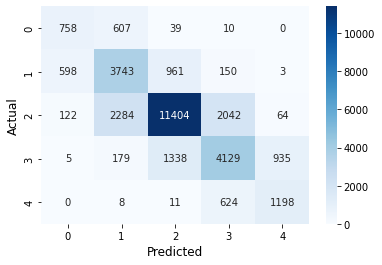


Classification Metrics

              precision    recall  f1-score   support

           0       0.51      0.54      0.52      1414
           1       0.55      0.69      0.61      5455
           2       0.83      0.72      0.77     15916
           3       0.59      0.63      0.61      6586
           4       0.54      0.65      0.59      1841

    accuracy                           0.68     31212
   macro avg       0.61      0.64      0.62     31212
weighted avg       0.70      0.68      0.69     31212



In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
v=[]
idx=[]
for i in preds:
    for j in i:
        y=j.to('cpu').detach().numpy().copy()
        v.append(y)
        idx.append(np.argmax(y))

cf_matrix = confusion_matrix(test.Sentiment.values, idx)
print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(test.Sentiment.values, idx)

print("\nClassification Metrics\n")
print(lr_report)

##Liner 

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss: 3367.7909992039204, Validation Loss: 784.0773965716362
Epoch: 1, Training Loss: 2684.3321438729763, Validation Loss: 777.7406460344791
Epoch: 2, Training Loss: 2672.857094556093, Validation Loss: 778.9503777325153
Epoch: 3, Training Loss: 2669.6422431468964, Validation Loss: 779.941468000412
Epoch: 4, Training Loss: 2671.0513441860676, Validation Loss: 779.4944198131561
Epoch: 5, Training Loss: 2672.7655266821384, Validation Loss: 779.3789431452751
Epoch: 6, Training Loss: 2673.8846693336964, Validation Loss: 779.5057361125946
Epoch: 7, Training Loss: 2674.285539060831, Validation Loss: 778.9833252429962
Epoch: 8, Training Loss: 2669.782598167658, Validation Loss: 777.7324733436108
Epoch: 9, Training Loss: 2669.5538488030434, Validation Loss: 780.556158721447
Epoch: 10, Training Loss: 2665.9781152009964, Validation Loss: 778.8497868776321
Epoch: 11, Training Loss: 2669.5642989575863, Validation Loss: 778.8871302008629
Epoch: 12, Training Loss: 2660.533479422331

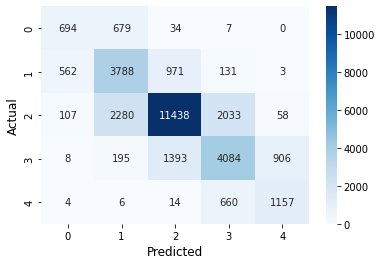


Classification Metrics

              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1414
           1       0.55      0.69      0.61      5455
           2       0.83      0.72      0.77     15916
           3       0.59      0.62      0.60      6586
           4       0.54      0.63      0.58      1841

    accuracy                           0.68     31212
   macro avg       0.60      0.63      0.61     31212
weighted avg       0.70      0.68      0.68     31212



In [7]:
max_epoch = 31
train_loss_ = []
test_loss_ = []
model = CustomBERTModel()
model.cuda()

pred_list = []
preds=[]
for epoch in range(max_epoch):
    train_ = train_model(model, epoch, add_on="linear")
    train_loss_.append(train_)
    preds, test_ = valid_model(model, add_on="linear")
    pred_list.append(preds)
    print("Epoch: {}, Training Loss: {}, Validation Loss: {}".format(epoch, train_, test_))


torch.save(model.state_dict(), "Linear_model.pth")


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
v=[]
idx=[]
for i in preds:
    for j in i:
        y=j.to('cpu').detach().numpy().copy()
        v.append(y)
        idx.append(np.argmax(y))

cf_matrix = confusion_matrix(test.Sentiment.values, idx)
print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(test.Sentiment.values, idx)

print("\nClassification Metrics\n")
print(lr_report)

id_df = pd.DataFrame(test.Sentiment.values, columns=['true'])
pred_df = pd.DataFrame(idx, columns=['pred'])
Submission_df = pd.concat([id_df, pred_df], axis=1)
Submission_df.head()

Submission_df.to_csv('BERT+Linear.csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss: 3475.9192714989185, Validation Loss: 774.384990811348
Epoch: 1, Training Loss: 2699.474634438753, Validation Loss: 781.0791279673576
Epoch: 2, Training Loss: 2689.2606858611107, Validation Loss: 787.0179260075092
Epoch: 3, Training Loss: 2683.688359051943, Validation Loss: 787.1830821931362
Epoch: 4, Training Loss: 2682.631347298622, Validation Loss: 786.6551372110844
Epoch: 5, Training Loss: 2681.1580915153027, Validation Loss: 784.4574118554592
Epoch: 6, Training Loss: 2679.805150747299, Validation Loss: 784.3619524240494
Epoch: 7, Training Loss: 2686.789523899555, Validation Loss: 788.9180709719658
Epoch: 8, Training Loss: 2687.8325549960136, Validation Loss: 782.8609920740128
Epoch: 9, Training Loss: 2683.0109889805317, Validation Loss: 781.5501190125942
Epoch: 10, Training Loss: 2678.4922966063023, Validation Loss: 783.7673917710781
Epoch: 11, Training Loss: 2676.3639419078827, Validation Loss: 783.3252934515476
Epoch: 12, Training Loss: 2676.9528198838234

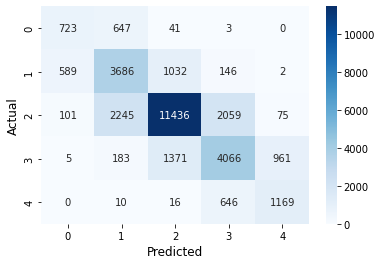


Classification Metrics

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1414
           1       0.54      0.68      0.60      5455
           2       0.82      0.72      0.77     15916
           3       0.59      0.62      0.60      6586
           4       0.53      0.63      0.58      1841

    accuracy                           0.68     31212
   macro avg       0.60      0.63      0.61     31212
weighted avg       0.69      0.68      0.68     31212



In [ ]:
max_epoch = 31
train_loss_ = []
test_loss_ = []
model = CustomBERTModel()
model.cuda()

pred_list = []
preds=[]
for epoch in range(max_epoch):
    train_ = train_model(model, epoch, add_on="lstm", weighted = False)
    train_loss_.append(train_)
    preds, test_ = valid_model(model, add_on="lstm", weighted = False)
    pred_list.append(preds)
    print("Epoch: {}, Training Loss: {}, Validation Loss: {}".format(epoch, train_, test_))

v=[]
idx=[]
for i in preds:
    for j in i:
        y=j.to('cpu').detach().numpy().copy()
        v.append(y)
        idx.append(np.argmax(y))

cf_matrix = confusion_matrix(test.Sentiment.values, idx)
print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(test.Sentiment.values, idx)

print("\nClassification Metrics\n")
print(lr_report)

id_df = pd.DataFrame(test.Sentiment.values, columns=['true'])
pred_df = pd.DataFrame(idx, columns=['pred'])
Submission_df = pd.concat([id_df, pred_df], axis=1)
Submission_df.head()

Submission_df.to_csv('BERT+Linear.csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss: 3101.9273144304752, Validation Loss: 706.9892759621143
Epoch: 1, Training Loss: 2469.09191814065, Validation Loss: 721.1106939911842
Epoch: 2, Training Loss: 2464.9325243085623, Validation Loss: 718.0783407390118
Epoch: 3, Training Loss: 2460.613792926073, Validation Loss: 719.2750425338745
Epoch: 4, Training Loss: 2460.434380531311, Validation Loss: 719.1873587071896
Epoch: 5, Training Loss: 2458.9444582015276, Validation Loss: 719.0341478586197
Epoch: 6, Training Loss: 2459.5474953353405, Validation Loss: 718.7526479959488
Epoch: 7, Training Loss: 2460.7782364934683, Validation Loss: 719.5747478604317
Epoch: 8, Training Loss: 2456.922312170267, Validation Loss: 720.2050676345825
Epoch: 9, Training Loss: 2459.957531452179, Validation Loss: 718.4292905330658
Epoch: 10, Training Loss: 2457.017953157425, Validation Loss: 717.9160916209221
Epoch: 11, Training Loss: 2453.023136675358, Validation Loss: 718.2988543212414
Epoch: 12, Training Loss: 2453.845438718796, V

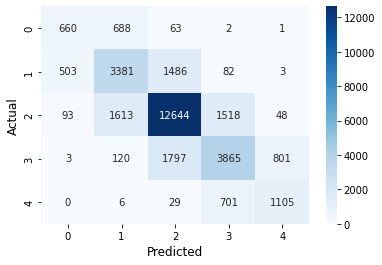


Classification Metrics

              precision    recall  f1-score   support

           0       0.52      0.47      0.49      1414
           1       0.58      0.62      0.60      5455
           2       0.79      0.79      0.79     15916
           3       0.63      0.59      0.61      6586
           4       0.56      0.60      0.58      1841

    accuracy                           0.69     31212
   macro avg       0.62      0.61      0.61     31212
weighted avg       0.69      0.69      0.69     31212



In [ ]:
max_epoch = 31
train_loss_ = []
test_loss_ = []
model = CustomBERTModel()
model.cuda()

pred_list = []
preds=[]
for epoch in range(max_epoch):
    train_ = train_model(model, epoch, add_on="linear", weighted = False)
    train_loss_.append(train_)
    preds, test_ = valid_model(model, add_on="linear", weighted = False)
    pred_list.append(preds)
    print("Epoch: {}, Training Loss: {}, Validation Loss: {}".format(epoch, train_, test_))

v=[]
idx=[]
for i in preds:
    for j in i:
        y=j.to('cpu').detach().numpy().copy()
        v.append(y)
        idx.append(np.argmax(y))

cf_matrix = confusion_matrix(test.Sentiment.values, idx)
print("Confusion Matrix\n")
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.show()

lr_report = classification_report(test.Sentiment.values, idx)

print("\nClassification Metrics\n")
print(lr_report)

id_df = pd.DataFrame(test.Sentiment.values, columns=['true'])
pred_df = pd.DataFrame(idx, columns=['pred'])
Submission_df = pd.concat([id_df, pred_df], axis=1)
Submission_df.head()

Submission_df.to_csv('BERT+Linear.csv', index=False)